<a href="https://colab.research.google.com/github/geekpascal/hygieia_diesease_grading/blob/main/hygieia_diesease_grading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.9 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import efficientnet.tfkeras as efn
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler

### Using the Image Data Generator

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    width_shift_range=0.3,
    height_shift_range=0.5,
    rotation_range=40,         # New augmentation for rotation
    shear_range=0.2,           # New augmentation for shearing
    horizontal_flip=True,      # New augmentation for horizontal flipping
    channel_shift_range=0.2,   # New augmentation for channel shifting
    fill_mode='nearest',       # How to fill new pixels
    validation_split=0.2       # Split for validation
)
train_data = datagen.flow_from_directory('../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images',
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode = 'categorical',
                                                     subset = 'training')

valid_data = datagen.flow_from_directory('../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images',
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode = 'categorical',
                                                     subset = 'validation')

FileNotFoundError: [Errno 2] No such file or directory: '../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'

## Defining the learning rate scheduler

In [ ]:
def lr_rate(epoch, lr, rates=None):
    if rates is None:
        rates = {
            0: 0.0001,  # from epoch 0 to 9
            10: 0.0005, # from epoch 10 to 15
            16: 0.0001  # from epoch 16 to 30
        }

    for start_epoch, rate in sorted(rates.items()):
        if epoch < start_epoch:
            return rate

    # Default exponential decay after the defined epochs
    return lr * (epoch / (1 + epoch))

In [ ]:
lr_callback= LearningRateScheduler(lr_rate)

## Using EfficientNet for Transfer Learning

In [ ]:
# Build the model
model = tf.keras.Sequential([
    efn.EfficientNetB0(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    ),
    layers.GlobalAveragePooling2D(),  # Replaces Flatten
    layers.Dropout(0.5),              # Add Dropout for regularization
    layers.Dense(512, activation='relu'), # Add a Dense layer with ReLU activation
    layers.BatchNormalization(),      # Add Batch Normalization
    layers.Dropout(0.5),              # Another Dropout layer
    layers.Dense(5, activation='softmax')
])
model.compile(optimizer="Adam",loss='categorical_crossentropy',metrics=['acc'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2

In [ ]:

history=model.fit_generator(train_data,validation_data = valid_data,callbacks=[lr_callback],epochs=40,verbose=1)


Epoch 1/40
92/92 [==============================] - 81s 885ms/step - loss: 1.4211 - acc: 0.5916 - val_loss: 0.8731 - val_acc: 0.6854 - lr: 5.0000e-04
Epoch 2/40
92/92 [==============================] - 57s 616ms/step - loss: 0.9399 - acc: 0.6967 - val_loss: 0.9205 - val_acc: 0.6813 - lr: 5.0000e-04
Epoch 3/40
92/92 [==============================] - 57s 617ms/step - loss: 0.8055 - acc: 0.7097 - val_loss: 0.8249 - val_acc: 0.7237 - lr: 5.0000e-04
Epoch 4/40
92/92 [==============================] - 56s 613ms/step - loss: 0.7298 - acc: 0.7346 - val_loss: 0.6478 - val_acc: 0.7729 - lr: 5.0000e-04
Epoch 5/40
92/92 [==============================] - 57s 622ms/step - loss: 0.6844 - acc: 0.7404 - val_loss: 0.6151 - val_acc: 0.7880 - lr: 5.0000e-04
Epoch 6/40
92/92 [==============================] - 57s 619ms/step - loss: 0.6190 - acc: 0.7690 - val_loss: 0.6064 - val_acc: 0.7825 - lr: 5.0000e-04
Epoch 7/40
92/92 [==============================] - 56s 613ms/step - loss: 0.6248 - acc: 0.7697 - va

In [ ]:
def display_training_curves(training, validation, title, subplot):
    """
    Displays training and validation curves.

    Args:
    training (list or array): Training data points.
    validation (list or array): Validation data points.
    title (str): Title of the plot, typically the metric being plotted.
    subplot (int): Subplot position.

    """
    # Initialize subplots on the first call
    if subplot % 10 == 1:
        plt.figure(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()

    # Create subplot
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')

    # Plot training and validation data
    ax.plot(training, label='Train')
    ax.plot(validation, label='Validation')

    # Set title and labels
    ax.set_title(f'Model {title}', fontsize=14)
    ax.set_ylabel(title, fontsize=12)
    ax.set_xlabel('Epoch', fontsize=12)

    # Display legend
    ax.legend()

    # Adjust layout
    plt.tight_layout()

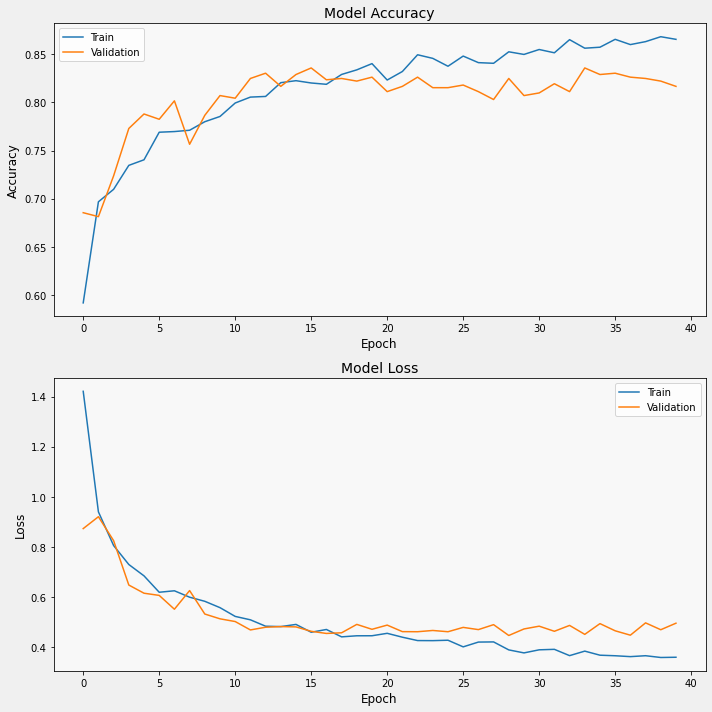

In [ ]:
display_training_curves(history.history['acc'], history.history['val_acc'], 'Accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 212)

plt.show()

In [ ]:
# Save the entire model to a HDF5 file
model.save('/kaggle/working/hygieia_dg.h5')